In [1]:
import os

# Limit the number of threads for various libraries
os.environ["MKL_NUM_THREADS"] = "12"  # For MKL (used by NumPy)
os.environ["NUMEXPR_NUM_THREADS"] = "12"  # For NumExpr
os.environ["VECLIB_MAXIMUM_THREADS"] = "12"  # For macOS Accelerate
os.environ["OPENBLAS_NUM_THREADS"] = "12"  # For OpenBLAS
os.environ["BLIS_NUM_THREADS"] = "12"  # For BLIS

# Print environment variables to verify
print("OMP_NUM_THREADS:", os.environ.get("OMP_NUM_THREADS"))
print("MKL_NUM_THREADS:", os.environ.get("MKL_NUM_THREADS"))
print("NUMEXPR_NUM_THREADS:", os.environ.get("NUMEXPR_NUM_THREADS"))
print("VECLIB_MAXIMUM_THREADS:", os.environ.get("VECLIB_MAXIMUM_THREADS"))
print("OPENBLAS_NUM_THREADS:", os.environ.get("OPENBLAS_NUM_THREADS"))
print("BLIS_NUM_THREADS:", os.environ.get("BLIS_NUM_THREADS"))

# Set PyTorch threads
import torch
torch.set_num_threads(18)
torch.set_num_interop_threads(18)

OMP_NUM_THREADS: None
MKL_NUM_THREADS: 12
NUMEXPR_NUM_THREADS: 12
VECLIB_MAXIMUM_THREADS: 12
OPENBLAS_NUM_THREADS: 12
BLIS_NUM_THREADS: 12


In [7]:
! pip install torchinfo

In [2]:
# WrappedProteinDataset & PCAExplainability - Usage Demo
# ======================================================
# This notebook demonstrates how to use WrappedProteinDataset and PCAExplainability
# to perform dimensionality reduction and interpret protein embedding data.

from project_root.dataset.dataset_loader import DatasetLoader
from project_root.dataset.protein_dataset import ProteinDataset
from project_root.dataset.wrapped_protein_dataset import WrappedProteinDataset
from project_root.utils.visualization import DataVisualizer

from torch.utils.data import DataLoader, TensorDataset

from project_root.dataset.protein_dataset import ProteinDataset
from project_root.dataset.wrapped_protein_dataset import WrappedProteinDataset
from project_root.models.protein_classifier import ProteinClassifier
from project_root.training.trainer import Trainer

# ------------------------------------------------------
# 📥 1. Load Dataset and Embeddings
# ------------------------------------------------------

# Define data path
path_dataset_folder = "../DATASETS/"

# Load data
loader = DatasetLoader(path_dataset_folder)
df = loader.load_dataframe()
embeddings, attention_weights = loader.load_embeddings_and_attention()

# Create ProteinDataset instance
protein_dataset = ProteinDataset(df, embeddings, attention_weights, solve_inconsistencies=True)

(877, 877)
(877, 877)
(1598, 1598)
(723, 723)
(723, 723)
(723, 723)
(723, 723)
(918, 918)
(918, 918)
(431, 431)
(431, 431)
(431, 431)
(431, 431)
(396, 396)
(396, 396)
(944, 944)
(944, 944)
(1077, 1077)
(1077, 1077)
(696, 696)
(696, 696)
(696, 696)
(696, 696)
(1248, 1248)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(760, 760)
(760, 760)
(760, 760)
(760, 760)
(315, 315)
(1294, 1294)
(467, 467)
(467, 467)
(83, 83)
(561, 561)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(870, 870)
(870, 870)
(870, 870)
(870, 870)
(1245, 1245)
(1245, 1245)
(1245, 1245)
(1245, 1245)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(1142, 1142)
(1142, 1142)
(1142, 1142)
(1142, 1142)
(314, 314)
(314, 314)
(314, 31

In [3]:
# ------------------------------------------------------
# 🧪 2. Create WrappedProteinDataset with Configurations
# ------------------------------------------------------

wrapped_dataset = WrappedProteinDataset(
    dataset=protein_dataset,
    reduce_method='pca',              # or 'tsne'
    pca_method='threshold',           # 'threshold', 'derivative', 'custom'
    threshold=0.95,
    random_projection_dim=50        # Random projection dim before PCA on attention weights
)

Converting embeddings and attention weights to NumPy arrays...
Applying random projection to reduce attention weights from 6255001 to 50 dimensions...
Applying dimensionality reduction using pca...


In [4]:
data_comb = wrapped_dataset.select_data(embedding = True, 
                                   attention_weights = True, 
                                   additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                   )

data_emb = wrapped_dataset.select_data(embedding = True,
                                   attention_weights = False,
                                   additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                   )


Adding additional columns to data...
Shape data before adding: (1219, 96) | Shape column: (1219, 1)
Shape data before adding: (1219, 97) | Shape column: (1219, 1)
Shape data before adding: (1219, 98) | Shape column: (1219, 1)
Final data shape: (1219, 99)
Adding additional columns to data...
Shape data before adding: (1219, 50) | Shape column: (1219, 1)
Shape data before adding: (1219, 51) | Shape column: (1219, 1)
Shape data before adding: (1219, 52) | Shape column: (1219, 1)
Final data shape: (1219, 53)


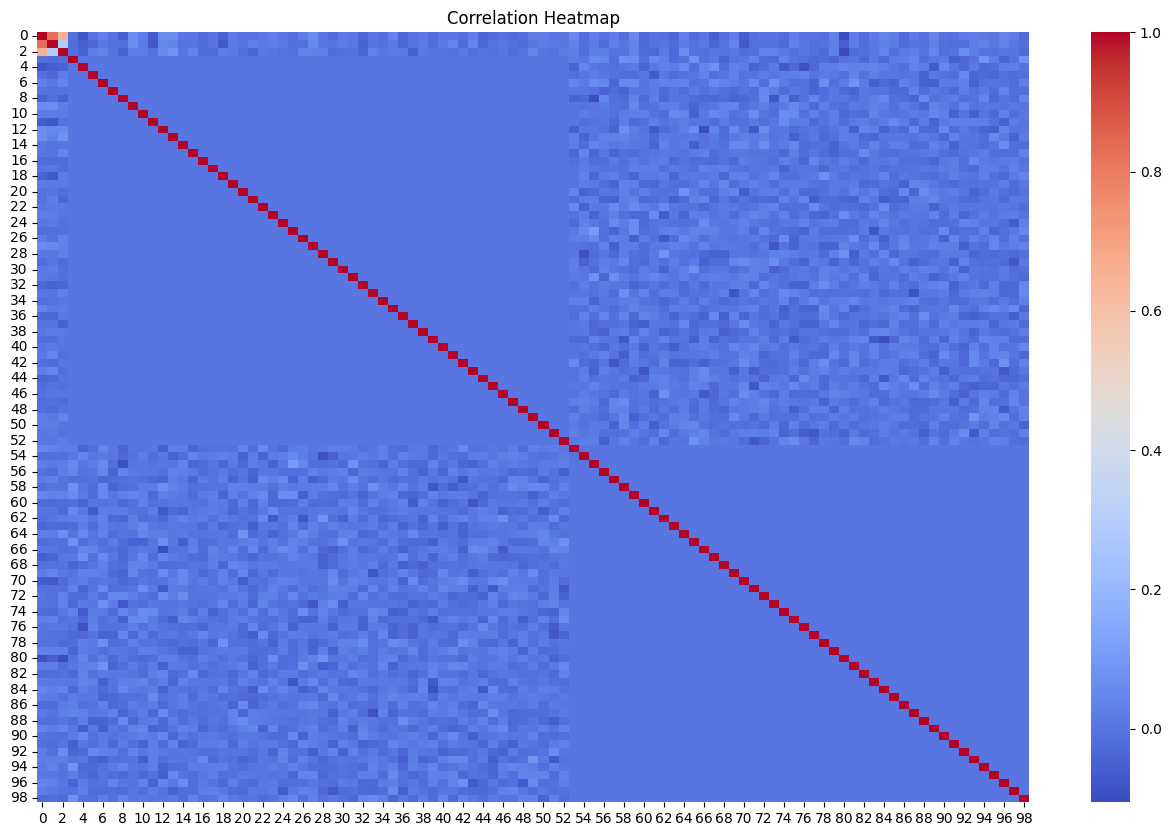

In [5]:
DataVisualizer.plot_correration_heatmap(data_comb)

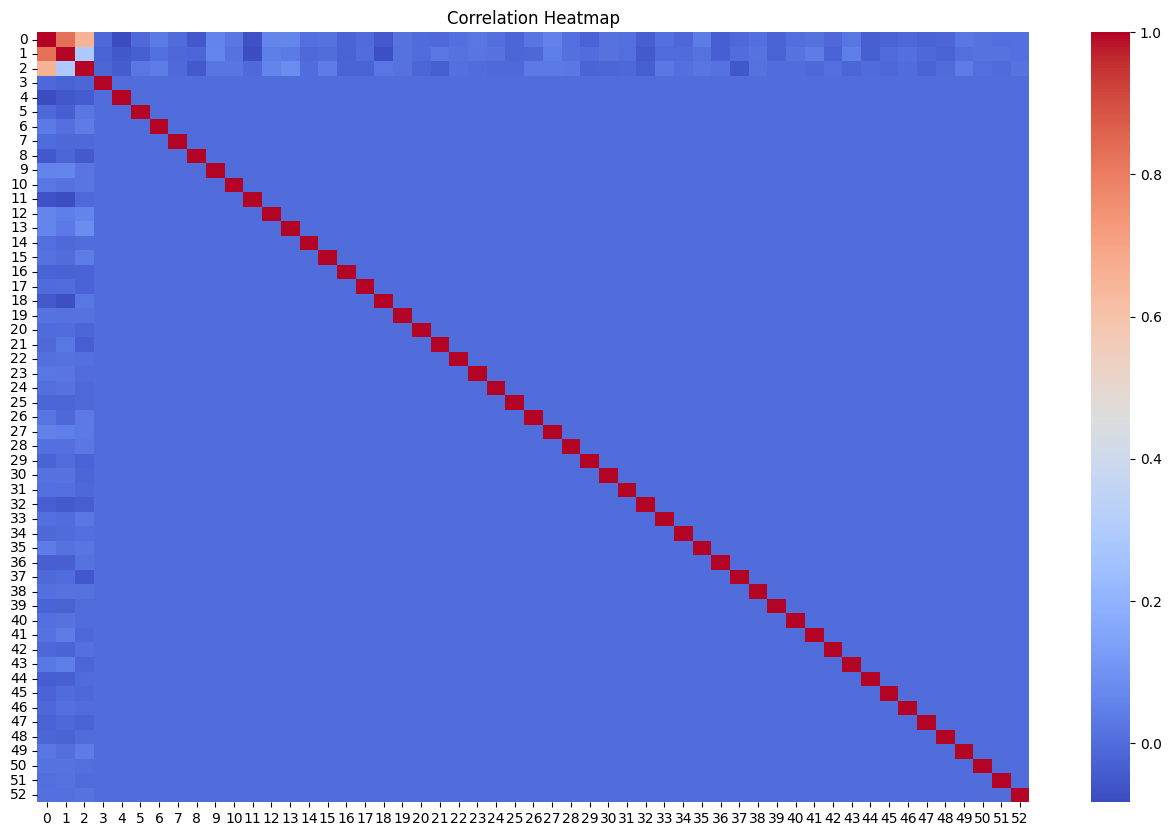

In [6]:
DataVisualizer.plot_correration_heatmap(data_emb)

In [7]:

def train_model(data, num_epochs=200, seed=2025):

    # Set random seed for reproducibility
    torch.manual_seed(seed)

    # -----------------------------------------
    # 🧪 Prepare dataloaders
    # -----------------------------------------
    X = torch.tensor(data, dtype=torch.float32)
    y = torch.tensor(protein_dataset.get_labels(), dtype=torch.float32)

    dataset = TensorDataset(X, y)
    split = int(0.6 * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [split, len(dataset) - split])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # -----------------------------------------
    # 🧠 Build and train model
    # -----------------------------------------
    input_size = X.shape[1]
    model_fn = lambda size: ProteinClassifier(
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        input_size=input_size,
        output_size=1,
        num_hidden_layers=1,
        hidden_layers_mode='quadratic_increase'
    )

    trainer = Trainer(model_class=model_fn)
    train_losses, val_losses, train_accs, val_accs = trainer.train_and_validate(train_loader, test_loader, num_epochs=num_epochs)

    # -----------------------------------------
    # 📈 Visualize results and evaluate
    # -----------------------------------------
    trainer.plot_results(train_losses, val_losses, train_accs, val_accs)
    trainer.evaluate_and_plot_confusion_matrix(test_loader)

    print("✅ ProteinClassifier + Trainer test complete")


Layer (type:depth-idx)                   Output Shape              Param #
ProteinClassifier                        [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 26]                   1,404
│    └─ReLU: 2-2                         [1, 26]                   --
│    └─Dropout: 2-3                      [1, 26]                   --
│    └─Linear: 2-4                       [1, 1]                    27
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
Epoch 1, Training Loss: 0.7945, Validation Loss: 0.7845, Training Accuracy: 0.2832, Validation Accuracy: 0.2480
Epoch 2, Training Loss: 0.7771, Validation Loss: 0.7680, Training Accuracy: 0.2750, Validation Accuracy: 0.2152
Epoch 3, Training Loss: 0.7572, Validation Loss: 0.7528, Training Acc

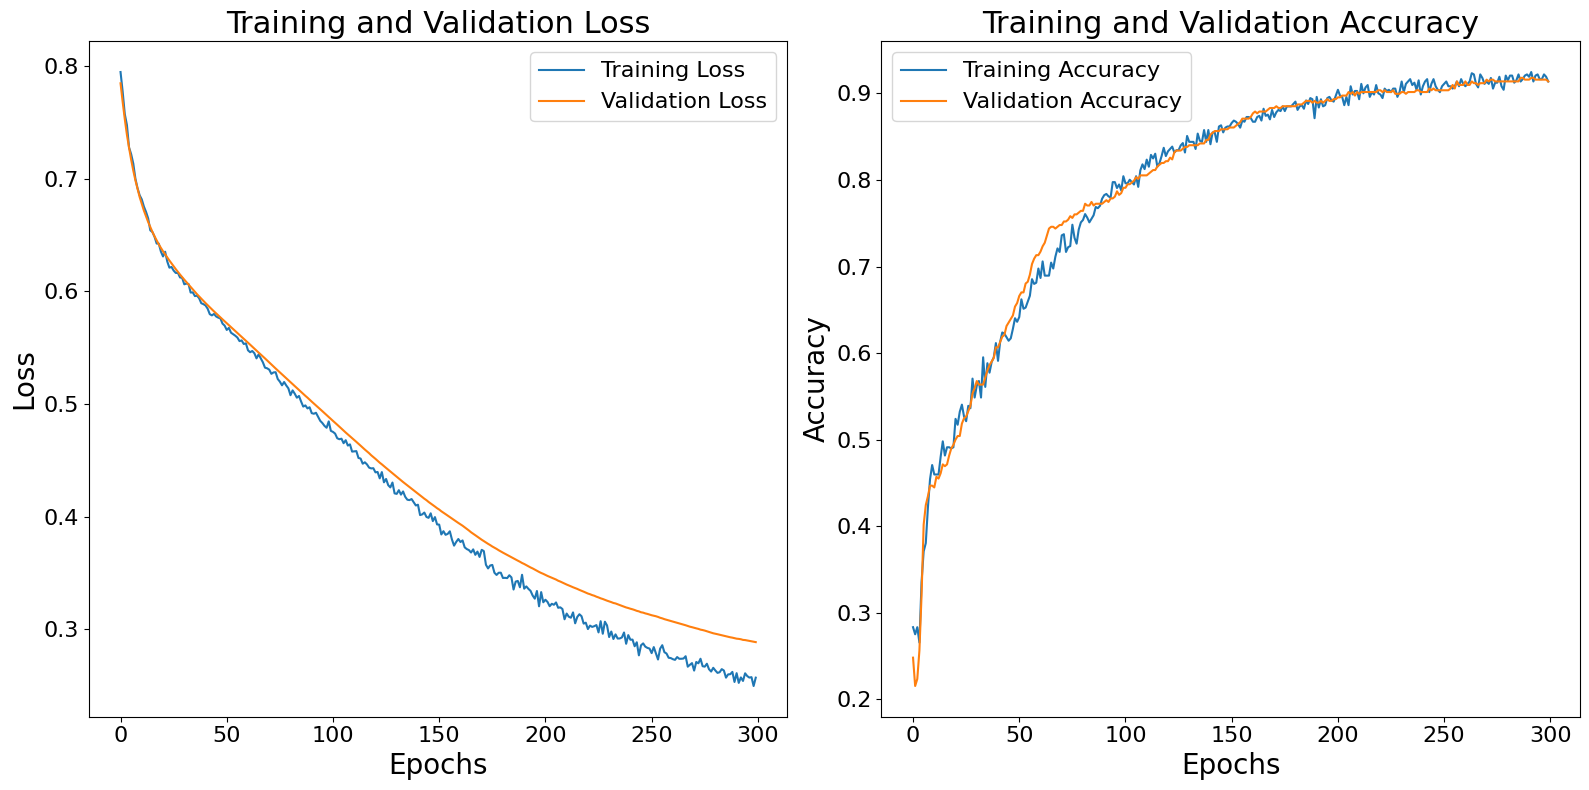

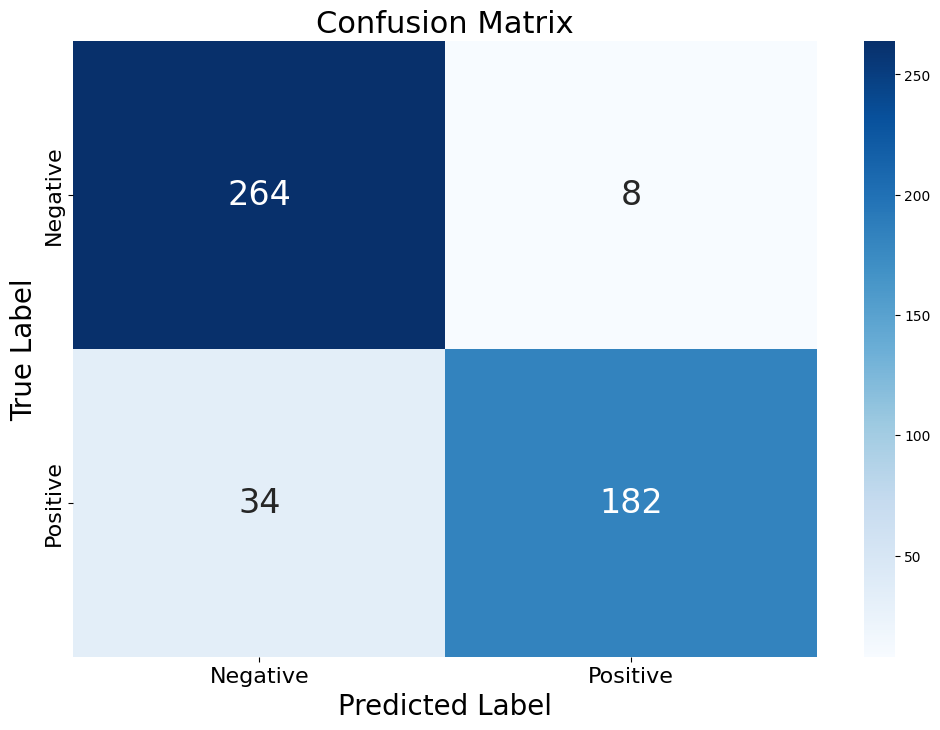


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.89      0.97      0.93       272
    Positive       0.96      0.84      0.90       216

    accuracy                           0.91       488
   macro avg       0.92      0.91      0.91       488
weighted avg       0.92      0.91      0.91       488

Especificidad: 0.9706
Estadístico Kappa: 0.8234
✅ ProteinClassifier + Trainer test complete


In [23]:
train_model(data_emb, num_epochs=300)

Layer (type:depth-idx)                   Output Shape              Param #
ProteinClassifier                        [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 49]                   4,900
│    └─ReLU: 2-2                         [1, 49]                   --
│    └─Dropout: 2-3                      [1, 49]                   --
│    └─Linear: 2-4                       [1, 1]                    50
Total params: 4,950
Trainable params: 4,950
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
Epoch 1, Training Loss: 0.7719, Validation Loss: 0.7601, Training Accuracy: 0.4665, Validation Accuracy: 0.4570
Epoch 2, Training Loss: 0.7515, Validation Loss: 0.7429, Training Accuracy: 0.4514, Validation Accuracy: 0.4324
Epoch 3, Training Loss: 0.7367, Validation Loss: 0.7286, Training Acc

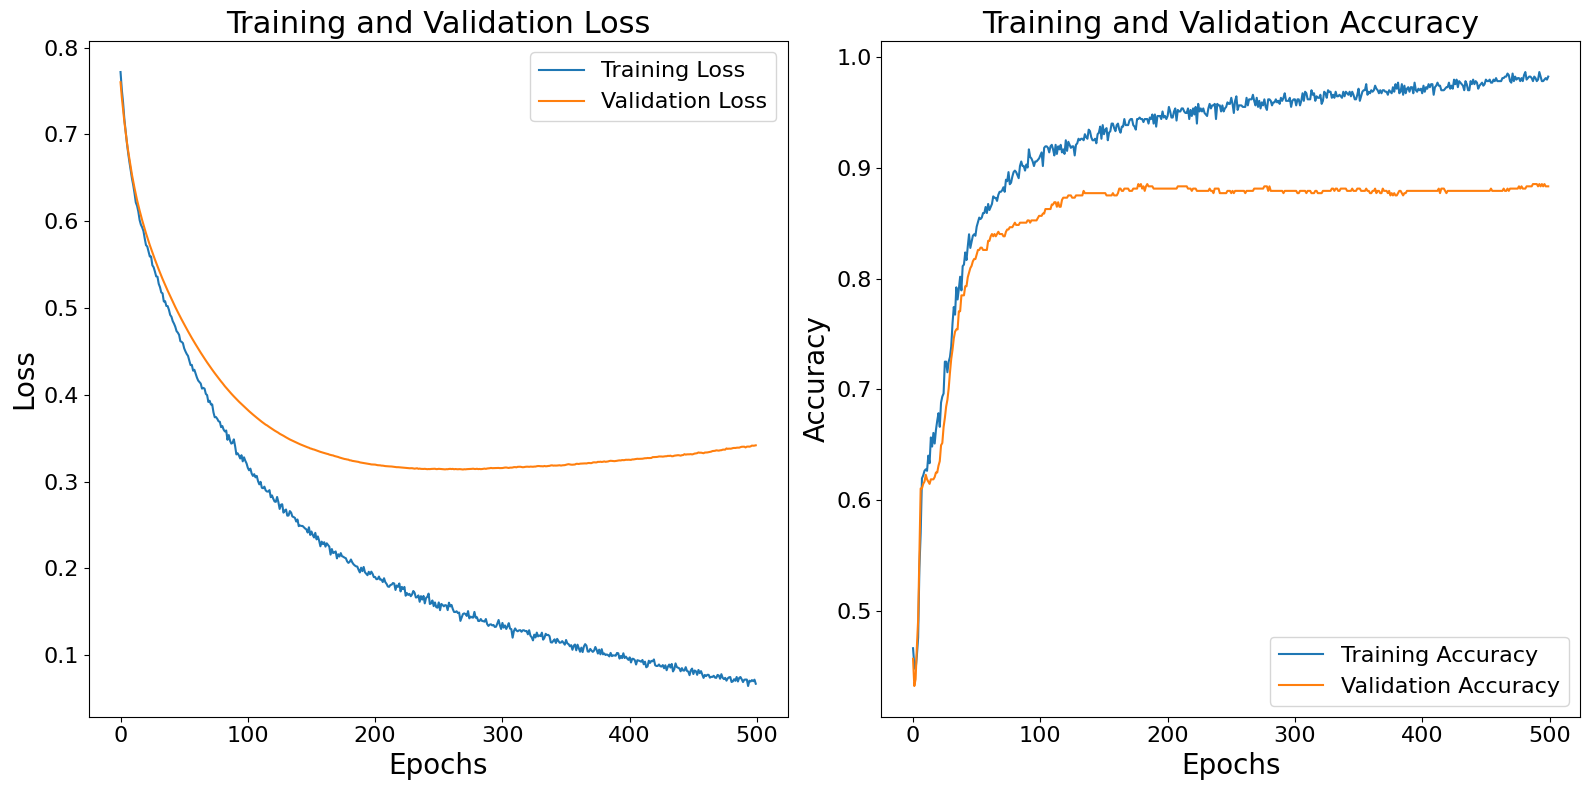

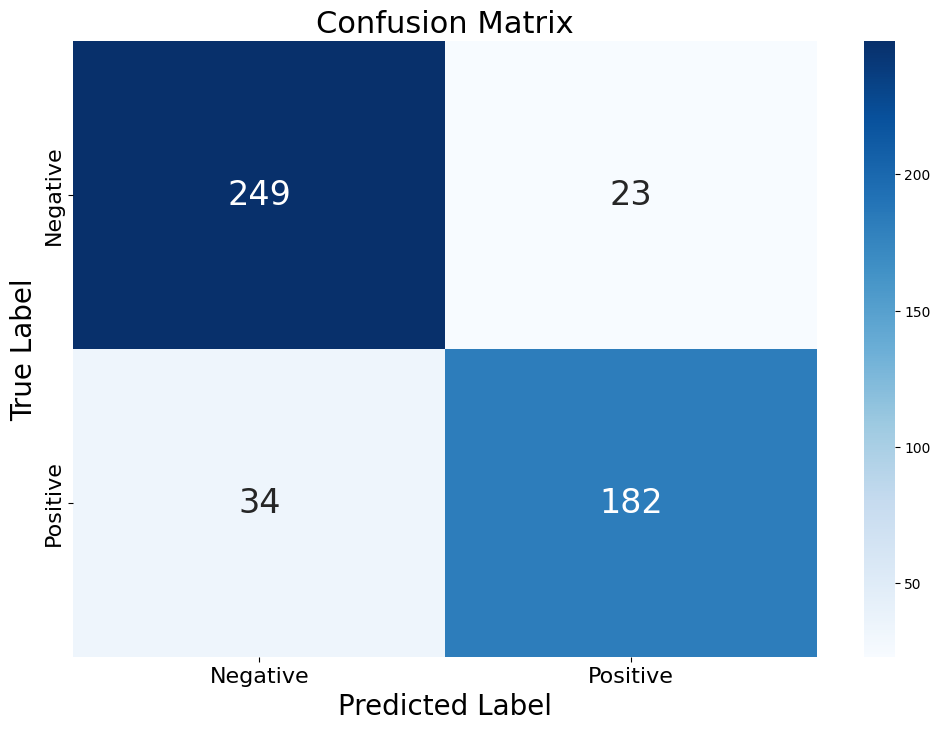


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90       272
    Positive       0.89      0.84      0.86       216

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488

Especificidad: 0.9154
Estadístico Kappa: 0.7620
✅ ProteinClassifier + Trainer test complete


In [8]:
train_model(data_comb, num_epochs=500)